In [1]:
import torch

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [2]:
from transformers import ViTForImageClassification, ViTFeatureExtractor

feature_extractor = ViTFeatureExtractor.from_pretrained('./nonstd-divide-bw=0.14333165606190812/')
model = ViTForImageClassification.from_pretrained('./nonstd-divide-bw=0.14333165606190812/').to(device)

/home/rkn/.local/share/virtualenvs/lab-work-gFKfzxI5/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/rkn/.local/share/virtualenvs/lab-work-gFKfzxI5/lib/python3.10/site-packages/transformers/models/vit/feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(


In [7]:
import torch
import pandas as pd
from torch.utils.data import Dataset
from PIL import Image
import os

def pil_loader(path):
    with open(path, 'rb') as f:
        img = Image.open(f)
        return img.convert('RGB')


class AffectNetDataset(Dataset):
    def __init__(self,
                 csv_file,
                 root,
                 mode='classification',
                 crop=False,
                 transform=None,
                 invalid_files=None):
        assert mode in ('valence', 'arousal', 'valence-arousal', 'classification')
        self.df = pd.read_csv(csv_file)
        self.root = root
        self.mode = mode
        self.crop = crop
        self.transform = transform
        self.invalid_files = invalid_files
        
        if self.invalid_files:
            self.df = self.df[~self.df['subDirectory_filePath'].isin(invalid_files)]
        
        self.df = self.df[~((self.df['expression'] == 9) | (self.df['expression'] == 10))].reset_index(drop=True)
    
    def __getitem__(self, idx):
        try:
            img = pil_loader(os.path.join(self.root, self.df['subDirectory_filePath'][idx]))
        except KeyError:
            raise IndexError
        if self.crop:
            img = img.crop((self.df['face_x'][idx],
                            self.df['face_y'][idx],
                            self.df['face_x'][idx]+self.df['face_width'][idx],
                            self.df['face_y'][idx]+self.df['face_height'][idx],))
        if self.transform:
            img = self.transform(img)
        if self.mode == 'classification':
            target = torch.tensor(self.df['expression'][idx])
        elif self.mode == 'valence':
            target = torch.tensor([self.df['valence'][idx]])
        elif self.mode == 'arousal':
            target = torch.tensor([self.df['arousal'][idx]])
        else:
            target = torch.tensor([self.df['valence'][idx],
                                   self.df['arousal'][idx]])
        return img.float(), target.float()

    def __len__(self):
        return len(self.df)

In [8]:
images_root = '../Affectnet/Manually_Annotated/Manually_Annotated_Images'
train_invalid_files = ['103/29a31ebf1567693f4644c8ba3476ca9a72ee07fe67a5860d98707a0a.jpg']
val_invalid_files = []
mode = 'valence-arousal'

In [9]:
from torchvision.transforms import (Compose,
                                    Normalize,
                                    Resize,
                                    ToTensor)
from torch.utils.data import DataLoader
from torch.utils.data.dataloader import default_collate

normalize = Normalize(mean=feature_extractor.image_mean,
                      std=feature_extractor.image_std)

transform = Compose([Resize(tuple(feature_extractor.size.values())),
                     ToTensor()])

train_dataset = AffectNetDataset('../Affectnet/training.csv',
                                 images_root,
                                 mode,
                                 transform=transform,
                                 invalid_files=train_invalid_files)
val_dataset = AffectNetDataset('../Affectnet/validation.csv',
                               images_root,
                               mode,
                               transform=transform,
                               invalid_files=val_invalid_files)

print('train:', len(train_dataset))
print('validation:', len(val_dataset))

train_dataloader = DataLoader(train_dataset, 256, collate_fn=lambda x: tuple(x_.to(device) for x_ in default_collate(x)))
val_dataloader = DataLoader(val_dataset, 256, collate_fn=lambda x: tuple(x_.to(device) for x_ in default_collate(x)))

train: 320739
validation: 4500


In [6]:
n_bins = 70

In [9]:
from typing import Dict
from matplotlib.figure import Figure
from matplotlib.axes import Axes

from tqdm import tqdm
import pandas as pd
import numpy as  np
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as cl

def rmse(x):
    x = x.drop(['valence', 'arousal'], axis=1)
    x = np.array(x.values)
    all_target, all_predict = np.split(x, 2, 1)
    valence_target, arousal_target = np.split(all_target, 2, 1)
    valence_pred, arousal_pred = np.split(all_predict, 2, 1)
    return pd.Series({'both_rmse': mean_squared_error(all_target, all_predict, squared=False),
                      'valence_rmse': mean_squared_error(valence_target, valence_pred, squared=False),
                      'arousal_rmse': mean_squared_error(arousal_target, arousal_pred, squared=False)})

def plot_metrics(fig: Figure, ax: Axes, table: pd.DataFrame, title: str):
    ax.set_aspect('equal', adjustable='box')
    pc = ax.pcolor(table.index, table.columns, table, cmap=cm.jet)
    ax.set_title(title)
    ax.set_xlabel('valence')
    ax.set_ylabel('arousal')
    fig.colorbar(pc, ax=ax)

def evaluate_model(dataloaders: Dict[str, DataLoader]):
    fig = plt.figure(figsize=(20, 10))
    for i, (mode, dataloader) in enumerate(dataloaders.items()):
        print(f'running prediction: {mode}')
        preds, targets = [], []
        for x, y in tqdm(dataloader):
            with torch.no_grad():
                output = model(x)
            preds.append(output.logits)
            targets.append(y)
        preds = torch.concat(preds).cpu()
        targets = torch.concat(targets).cpu()
        result = torch.concat((targets, preds), dim=1).cpu()
        
        valence_targets, arousal_targets = targets[:,0], targets[:,1]
        valence_preds, arousal_preds = preds[:,0], preds[:,1]

        all_rmse = mean_squared_error(targets, preds, squared=False)
        valence_rmse = mean_squared_error(valence_targets, valence_preds, squared=False)
        arousal_rmse = mean_squared_error(arousal_targets, arousal_preds, squared=False)
        print(f'{mode}: rmse')
        print('all:', all_rmse, 'valence:', valence_rmse, 'arousal:', arousal_rmse)
        
        df = pd.DataFrame(result.numpy())
        bins = np.linspace(-1, 1, n_bins+1)
        labels = np.linspace(-1, 1, n_bins)
        df = df.assign(valence=pd.cut(df[0], bins=bins, labels=labels),
                       arousal=pd.cut(df[1], bins=bins, labels=labels))
        bined = df.groupby(['valence', 'arousal'])
        bin_df = bined.apply(rmse).reset_index()
        both_tab = pd.pivot_table(bin_df, index='arousal', columns='valence', values='both_rmse')
        valence_tab = pd.pivot_table(bin_df, index='arousal', columns='valence', values='valence_rmse')
        arousal_tab = pd.pivot_table(bin_df, index='arousal', columns='valence', values='arousal_rmse')
        tab_dict = {
            'both': both_tab,
            'valence': valence_tab,
            'arousal': arousal_tab,
        }
        
        print(f'plotting metrics: {mode}')
        for j, (name, table) in enumerate(tab_dict.items()):
            ax = fig.add_subplot(len(dataloaders), len(tab_dict), i*len(tab_dict)+j+1)
            plot_metrics(fig, ax, table, f'{mode}: RMSE {name}')
    plt.tight_layout()
    plt.show()


running prediction: train


100%|██████████| 1253/1253 [35:53<00:00,  1.72s/it]


train: rmse
all: 0.2888735 valence: 0.30479392 arousal: 0.27298376
plotting metrics: train
running prediction: validation


100%|██████████| 18/18 [00:30<00:00,  1.68s/it]


validation: rmse
all: 0.38221902 valence: 0.38180482 arousal: 0.38263297
plotting metrics: validation


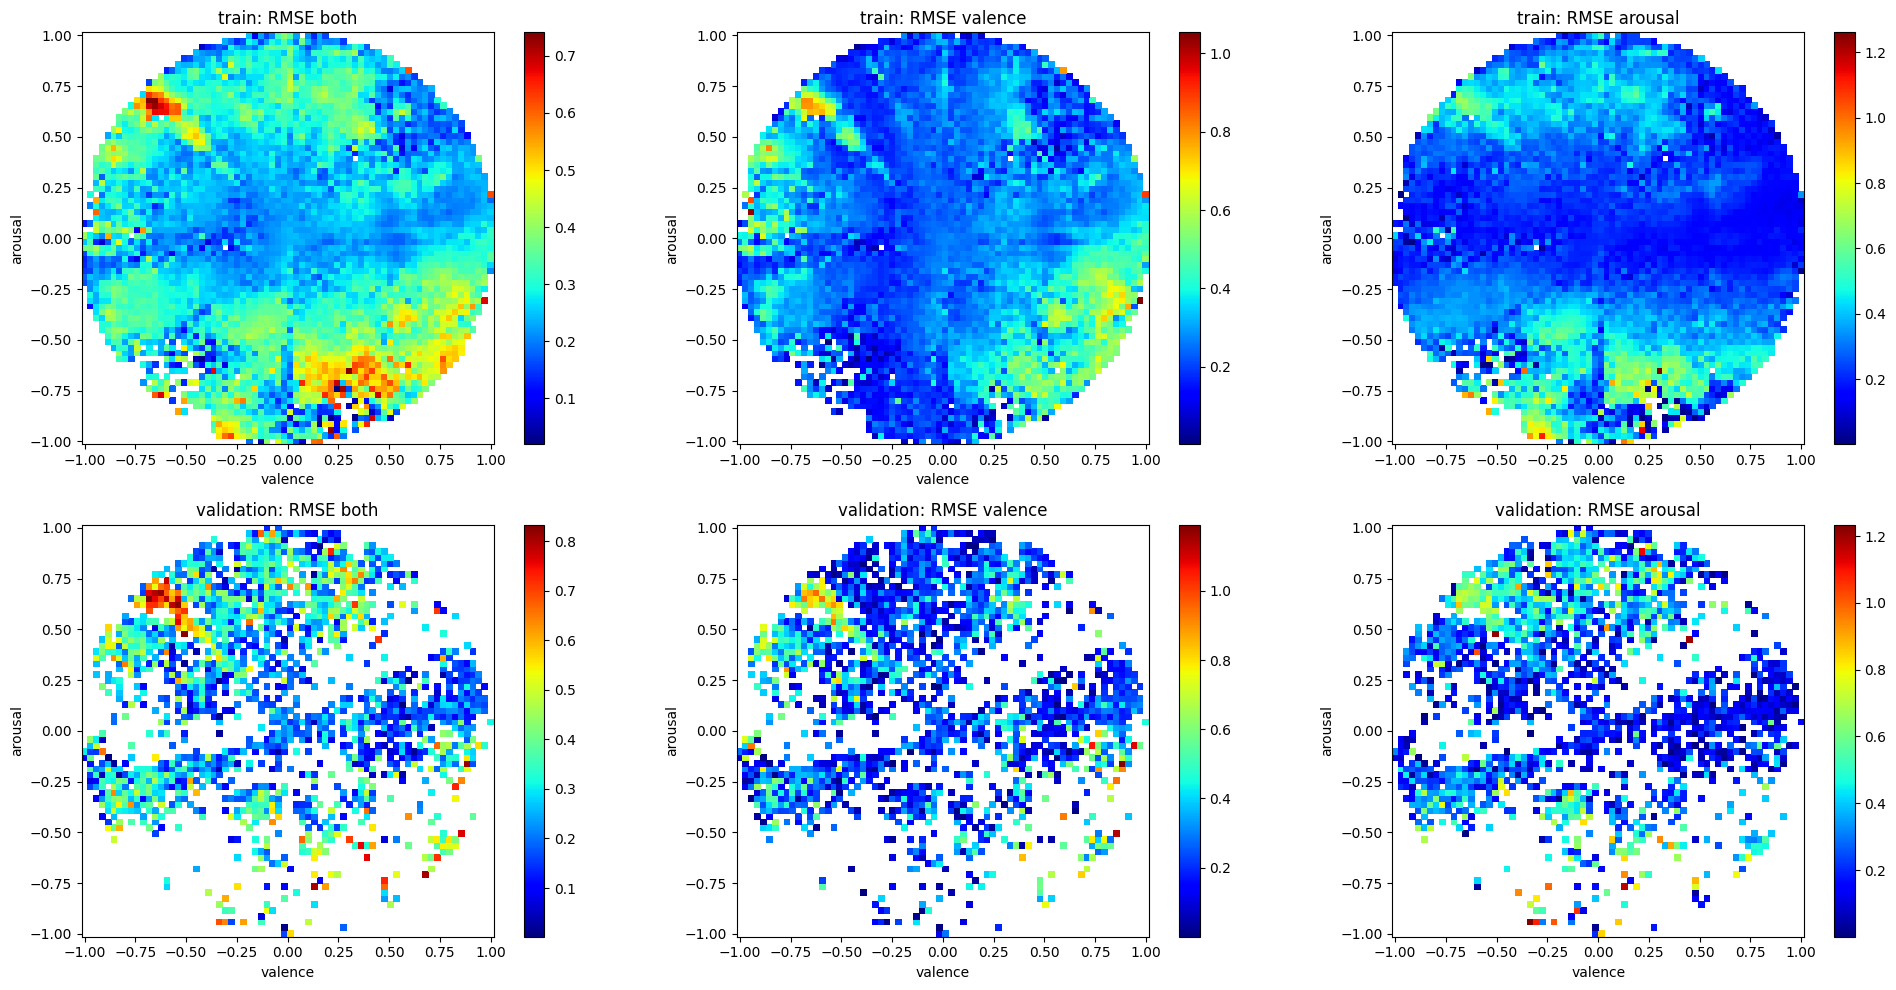

In [11]:
dataloaders = {
    'train': train_dataloader,
    'validation': val_dataloader,
}

evaluate_model(dataloaders)

In [11]:
from tqdm import tqdm

def CLS_tokens(model, tokenizer, dataset, device):
    tokens = []
    labels = []
    for img, label in tqdm(dataset):
        with torch.no_grad():
            token = model(img.unsqueeze(0).to(device), output_hidden_states=True).hidden_states[-1][0,0,:]
        tokens.append(token.cpu())
        labels.append(label)
    return torch.stack(tokens).squeeze(), torch.stack(labels)

In [12]:
from umap import UMAP
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.cm as cm

def plot_tokens(tokens, targets, n_neighbors):
    fig = plt.figure(figsize=(15, 15))
    # plt.subplots_adjust(wspace=0.4, hspace=0.6)
    umap = UMAP(n_neighbors=n_neighbors)
    xy = np.array(umap.fit_transform(tokens.numpy()))
    x = xy[:, 0]
    y = xy[:, 1]
    for i, category in enumerate(['valence', 'arousal']):
        z = targets[:, i]
        ax = fig.add_subplot(1, 2, i+1)
        ax.set_aspect('equal', adjustable='box')
        ax.set_xlabel('feature-1')
        ax.set_ylabel('feature-2')
        ax.set_title(category)
        mp = ax.scatter(x, y,
                        alpha=1,
                        c=z,
                        cmap='Oranges',
                        vmin=-1,
                        vmax=1,
                        s=3)
        fig.colorbar(mp, ax=ax, shrink=0.335)
    plt.tight_layout()
    plt.show()
    return fig


In [14]:
tokens, targets = CLS_tokens(model,
                             feature_extractor,
                             val_dataset,
                             device)
print(tokens.shape, targets.shape)

100%|██████████| 4500/4500 [01:17<00:00, 57.80it/s]

torch.Size([4500, 768]) torch.Size([4500, 2])


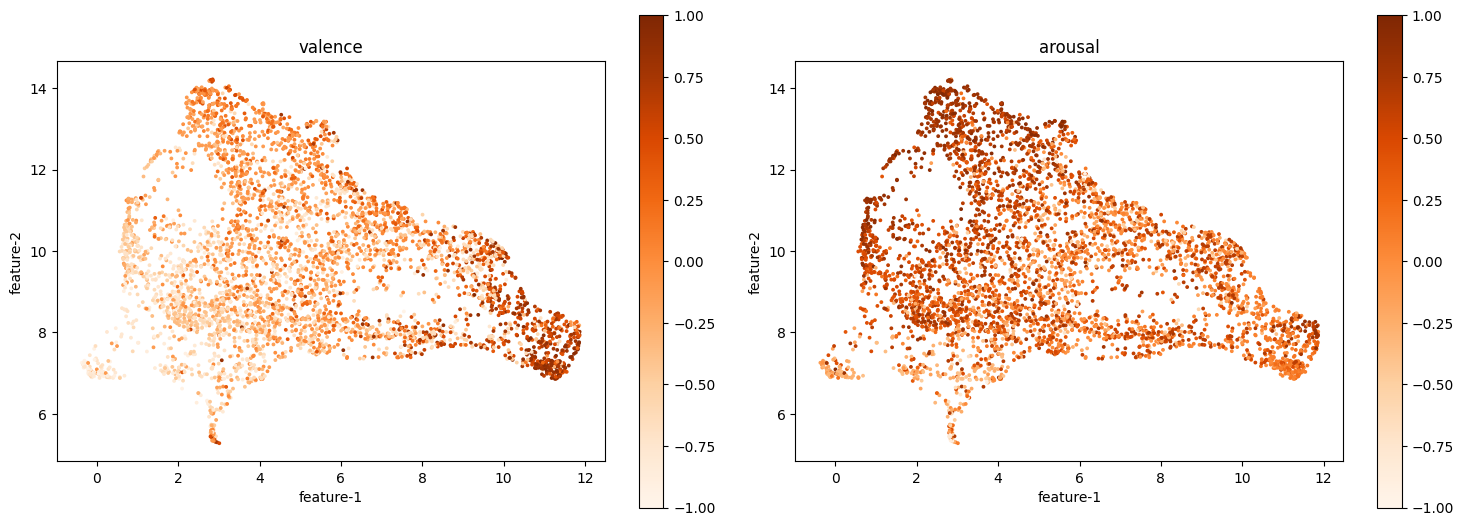

In [20]:
finetuned_fig = plot_tokens(tokens, targets, 20)

In [3]:
non_finetuned_model = ViTForImageClassification.from_pretrained('google/vit-base-patch16-224-in21k',
                                                                num_labels=2,
                                                                problem_type='regression').to(device)

Some weights of the model checkpoint at google/vit-base-patch16-224-in21k were not used when initializing ViTForImageClassification: ['pooler.dense.bias', 'pooler.dense.weight']
- This IS expected if you are initializing ViTForImageClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ViTForImageClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


100%|██████████| 4500/4500 [00:54<00:00, 82.09it/s] 


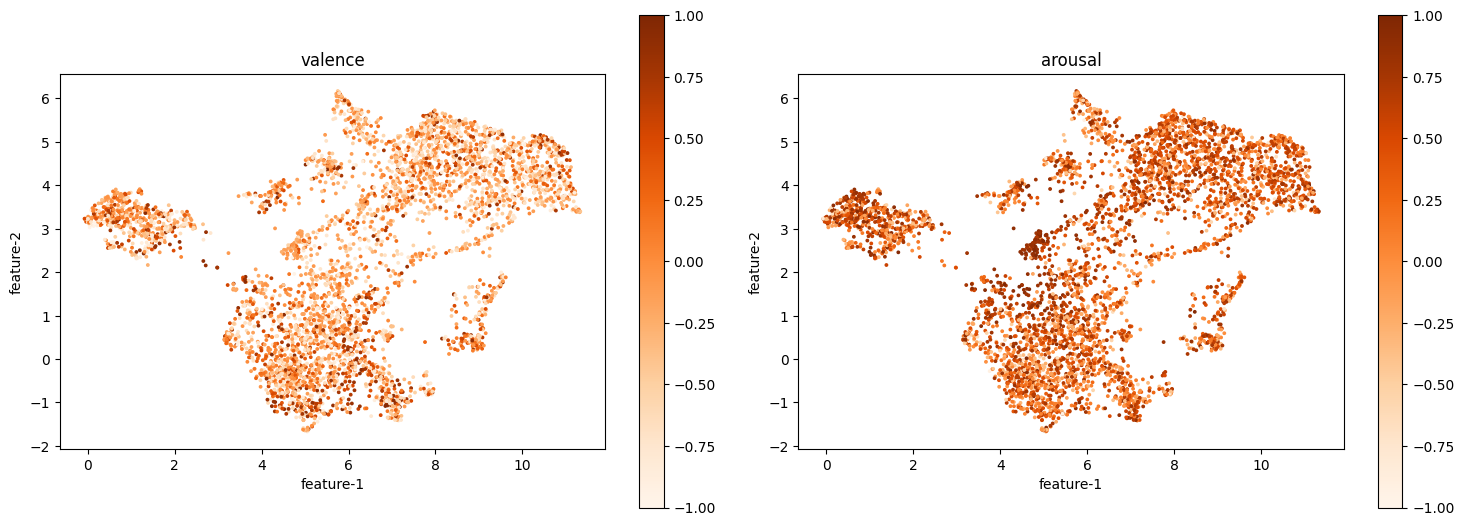

In [13]:
tokens, targets = CLS_tokens(non_finetuned_model,
                             feature_extractor,
                             val_dataset,
                             device)


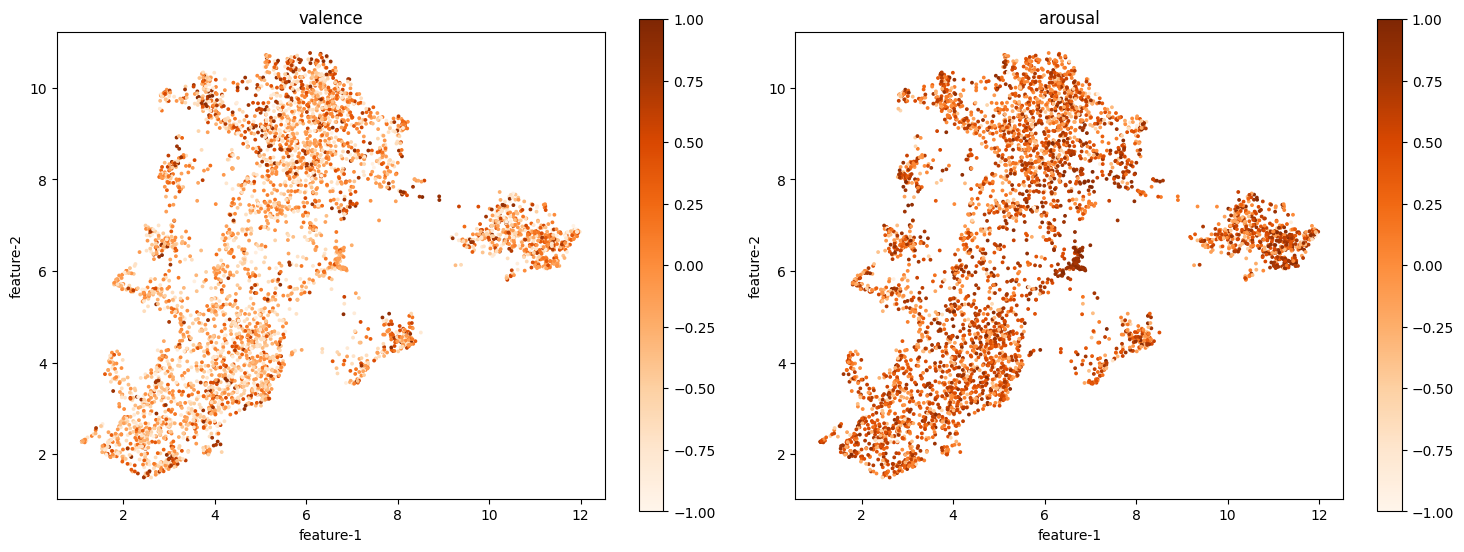

In [14]:
non_finetuned_fig = plot_tokens(tokens, targets, 20)